## EDA using Instacart Dataset

### Setting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 20
sns.set(style='whitegrid', palette='pastel', font_scale=1, rc={'font.family':'NanumGothic'})

In [2]:
# 수치를 좀 더 편하게 읽기 위해 사용하는 함수
# Instagram에서 팔로워 수를 나타내는 방법이랑 동일한 듯 하다.
def toReadable(v):
    value = round(v, 2) if isinstance(v, float) else v
    
    if value < 1000:
        return str(value)
    elif value < 1000000:
        return str(round(value/1000, 1)) + 'K'
    elif value >= 1000000:
        return str(round(value/1000000, 1)) + 'M'
    return value

### Load dataset

In [3]:
order_df = pd.read_csv('data/orders.csv')
order_products_df = pd.read_csv('data/order_products__prior.csv')
products_df = pd.read_csv('data/products.csv')

In [4]:
order_products_cnt_df = order_products_df.groupby('order_id').count()[['product_id']]
order_products_cnt_df.columns = ['product_cnt']

In [5]:
order_df = order_df.merge(order_products_cnt_df, left_on = 'order_id', right_index = True)

### Dataset Summary

In [6]:
total_user = len(order_df.user_id.unique()) # 전체 사용자 수
total_order = len(order_df) # 전체 주문 건수
total_ordered_product = len(order_products_df) # 전체 주문된 상품수
total_products = len(order_products_df.product_id.unique()) # 전체 상품수

print('Total user= {}'.format(toReadable(total_user)))
print('Total order= {} ({} orders per a user)'.format(toReadable(total_order), toReadable(total_order/total_user)))
print('Total product= {}'.format(toReadable(total_products)))
print('Total ordered product= {} ({} orders per a product)'.format(toReadable(total_ordered_product), toReadable(total_ordered_product/total_products)))

Total user= 206.2K
Total order= 3.2M (15.59 orders per a user)
Total product= 49.7K
Total ordered product= 32.4M (652.91 orders per a product)


### 📈 Weekly-Hour Analysis

상품 구매 현황이 요일별/시간별로 다른 특징을 나타낼 것으로 가정하고 이를 분석하였다.

In [7]:
# 요일별 index 분리
idx2day = 'Sun Mon Tue Wed Thu Fri Sat'.split()

In [8]:
def drawWeekHour(df, values, aggfunc=len, title=None, figsize=(18,5), cmap='Blues'):
    weekhour_df = df.pivot_table(index='order_dow', columns='order_hour_of_day', values=values, aggfunc=aggfunc).fillna(0)
    weekhour_df.index = [idx2day[idx] for idx in weekhour_df.index]
    
    plt.figure(figsize=figsize)
    f = sns.heatmap(weekhour_df, annot=True, fmt='1.1f', linewidths=.5, cmap=cmap)
    plt.xlabel('Hour')
    plt.ylabel('Day of Week')
    if title:
        plt.title(title, fontsize=15)

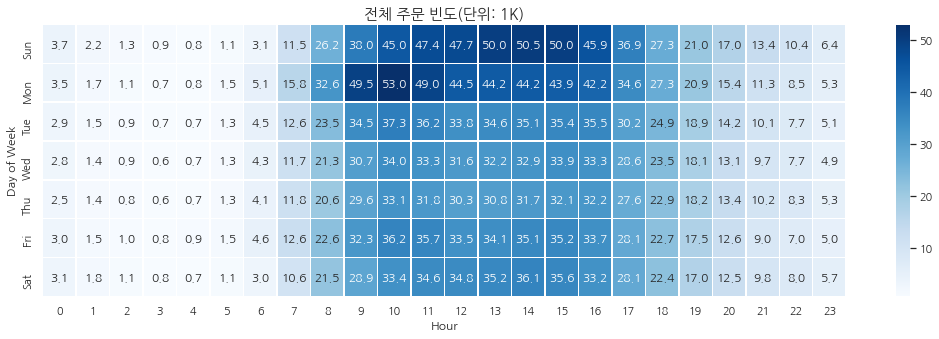

In [9]:
drawWeekHour(order_df, values='order_id', title='전체 주문 빈도(단위: 1K)', 
             aggfunc=lambda x: len(x)/1000)

전체 요일에 대해 대체적으로 각 요일마다 **8H에서 18H사이의 주문 빈도**가 다른 시간대에 비해 높은 것을 알 수 있다.

어떻게 해석하느냐에 따라 다르겠지만,

과연 이 수치가 **'단순히 한 고객이 주문을 여러번해서인지?'** 아니면 **'여러 고객이 주문을 했기 때문인지?'**   
이 두가지로 나누어서 확인해 볼 필요가 있다.

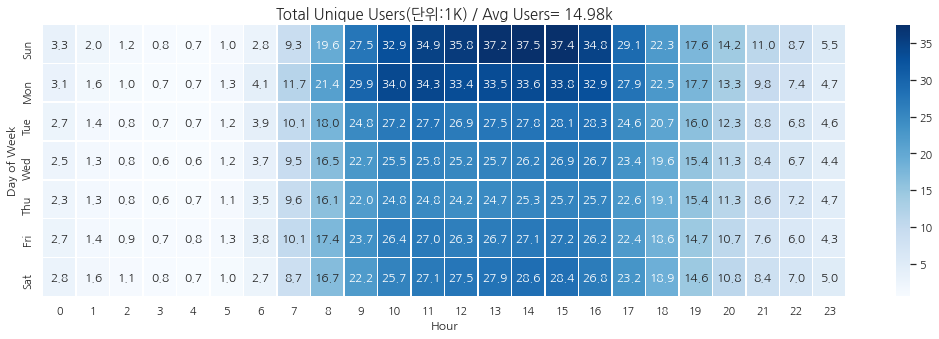

In [10]:
avg_users = round(order_df.groupby(['order_dow', 'order_hour_of_day']).agg({'user_id': lambda x: len(x.unique())/1000}).mean().values[0], 2)
drawWeekHour(order_df, values='user_id', title="Total Unique Users(단위:1K) / Avg Users= {}k".format(avg_users), 
             aggfunc=lambda x: len(x.unique())/1000)

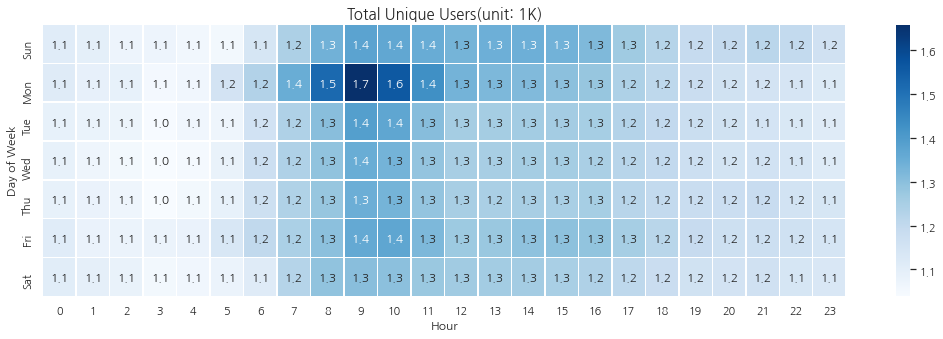

In [11]:
drawWeekHour(order_df, values='user_id', title='Total Unique Users(unit: 1K)',
             aggfunc=lambda x: len(x)/len(x.unique()), cmap='Blues')

수치를 비교해봤을 때, 고객 한 사람당 주문하는 양은 많지 않지만 여러 명의 고객이 주문을 함으로써 주문량이 많아지는 것을 확인할 수 있다.

두 경우에서 특히 **월요일 오전 9시**의 주문량이 다른 시간대에 비해 높았는데, 이 시간에는 고객들이 어떤 물건을 사는 것일까?

In [12]:
merge_order_products_df = order_products_df.merge(order_df, on='order_id')
merge_order_products_df = merge_order_products_df.merge(products_df, on='product_id')

In [13]:
order_products_9H_df = merge_order_products_df[merge_order_products_df.order_hour_of_day == 9]
grouped = order_products_9H_df[:].groupby(['order_dow'])

In [14]:
topn = 5
popular_products_9H = list() # 오전 9시에 가장 많이 팔린 상품 리스트

for dow, rows in grouped:
    sub_df = rows.groupby('product_id', as_index=False).agg({'order_id':len}).sort_values('order_id', ascending=False)[:topn]
    sub_df['dow'] = dow
    sub_df['rank'] = list(range(0, topn))
    popular_products_9H.append(sub_df)
    
popular_products_9H_df = pd.concat(popular_products_9H).sort_values(['rank', 'dow']).merge(products_df, on='product_id')\
.pivot(index='dow', columns='rank', values='product_name')

popular_products_9H_df.index = idx2day

In [15]:
popular_products_9H_df

rank,0,1,2,3,4
Sun,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado
Mon,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Tue,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Wed,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Thu,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Fri,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Sat,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado


요일별로 오전 9시에는 바나나, 딸기, 아보카드 같은 식재료가 많이 판매되는 것을 알 수 있다.

월요일에 특히 더 그 판매량이 높은 것 같다는 추측을 할 수 있다.

그렇다면 시간, 요일 상관없이 가장 잘 팔리는 상품은 무엇일까?
### 📈 Top 20 product (베스트셀러)

In [16]:
def topItemEachGroup(df, group_name, sort_name, topn):
    concat_list = list()
    for key, rows in df.groupby(group_name):
        sub_df = rows.sort_values(sort_name, ascending = False)[:topn]
        sub_df['rank'] = list(range(1, topn + 1))
        concat_list.append(sub_df)
    return pd.concat(concat_list)

def drawRankTrend(pivot_df, ylabel = 'Rank'):
    idx_max = pivot_df.index.max()
    rank_max = pivot_df.max().max()
    pivot_df = pivot_df.applymap(lambda x: rank_max - x + 1)
    pivot_df.plot(marker='o', figsize=(16,12), cmap='Dark2', xticks=pivot_df.index, legend=None)
    plt.yticks(np.arange(rank_max, 0, -1), np.arange(1, rank_max + 1))
    for name, rank in pivot_df.loc[idx_max].sort_values(ascending=False).dropna().iteritems():
        plt.text(idx_max*1.01, rank, name)
    plt.ylabel(ylabel)
    plt.show()

### 📈 Hour of day Trend by Top 20 product

In [17]:
hour_products_df = merge_order_products_df.groupby(['product_name', 'order_hour_of_day'], as_index=False).agg({'order_id':len})
bestseller_by_hour_df = topItemEachGroup(hour_products_df, 'order_hour_of_day', 'order_id', 20)
bestseller_by_hour_pivot = bestseller_by_hour_df.pivot(index='order_hour_of_day', columns='product_name', values='rank')

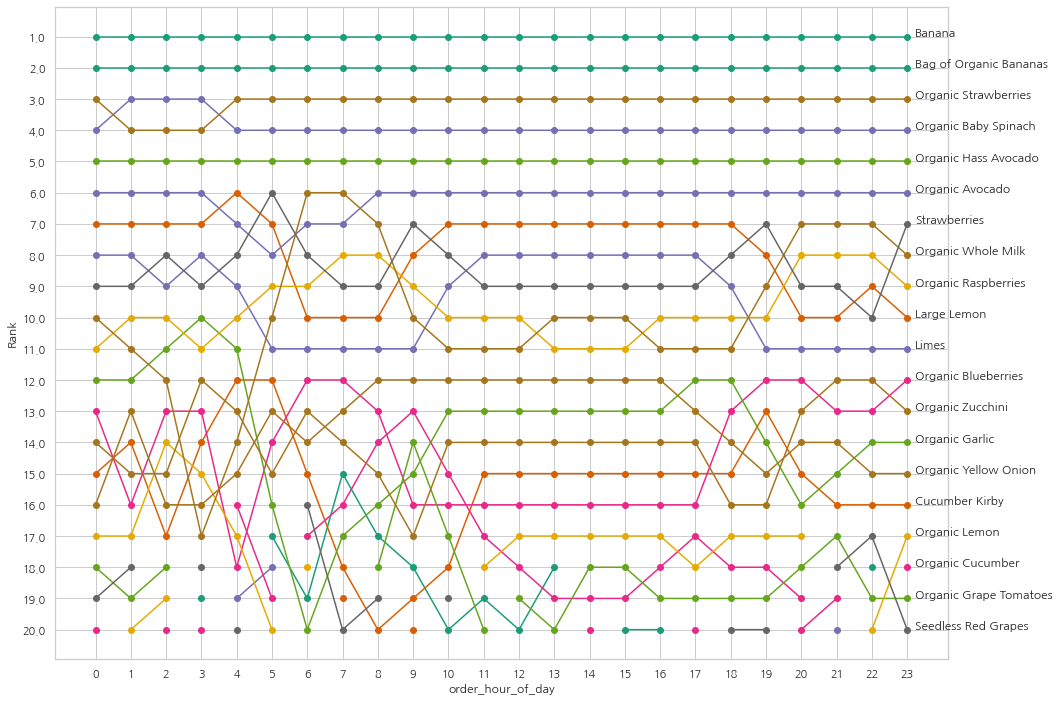

In [18]:
drawRankTrend(bestseller_by_hour_pivot)

1위에서 6위까지의 상품들은 시간에 따른 변화가 거의 없다.

**오전 시간대**에 상품들의 순위가 가장 많이 변화하는 것을 볼 수 있다.

### 📈 Day of week Trend by Top 20 product

In [19]:
bestseller_by_DoW_df = merge_order_products_df.groupby(['product_name', 'order_dow'], as_index=False).agg({'order_id':len})
bestseller_by_DoW_df = topItemEachGroup(bestseller_by_DoW_df, 'order_dow', 'order_id', 20)
bestseller_by_DoW_pivot = bestseller_by_DoW_df.pivot(index='order_dow', columns='product_name', values='rank')

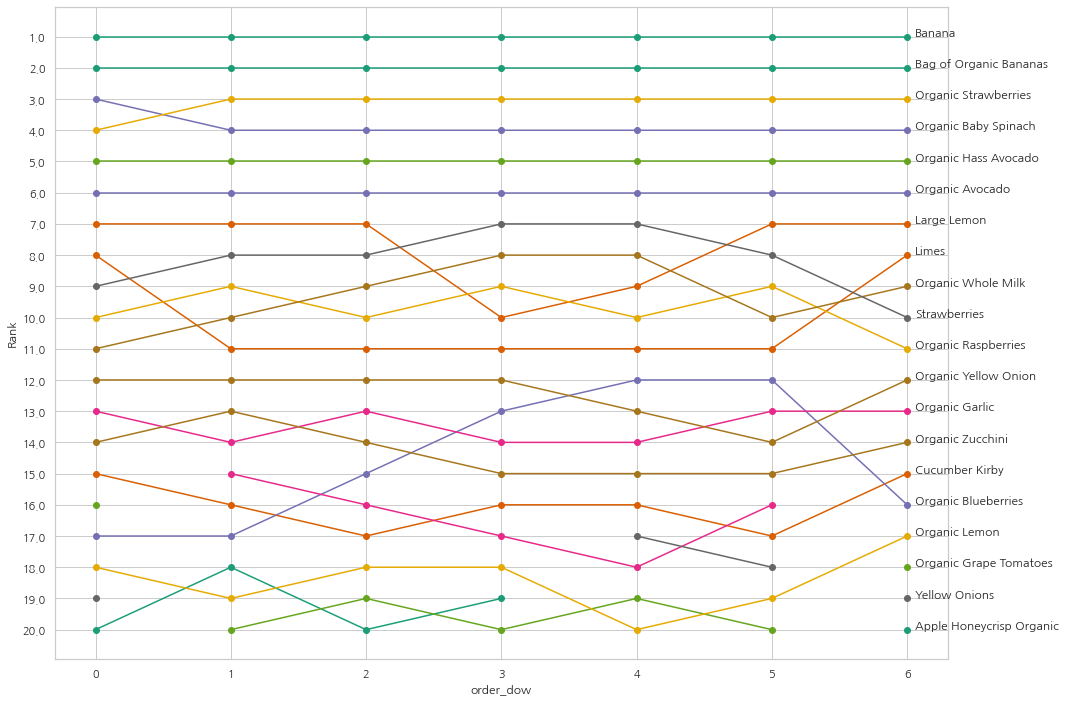

In [20]:
drawRankTrend(bestseller_by_DoW_pivot)

### 하나의 주문당 상품을 많이 담아서 구매하는 요일/시간대 분석
* 토요일/일요일에 특히 주문량이 많으며, 21~23시대에 한번에 주문하는 상품 개수가 많음을 알 수 있다.
* 비교적 여유로운 시간대에 주문량이 많다고 볼 수 있을 것 같다.

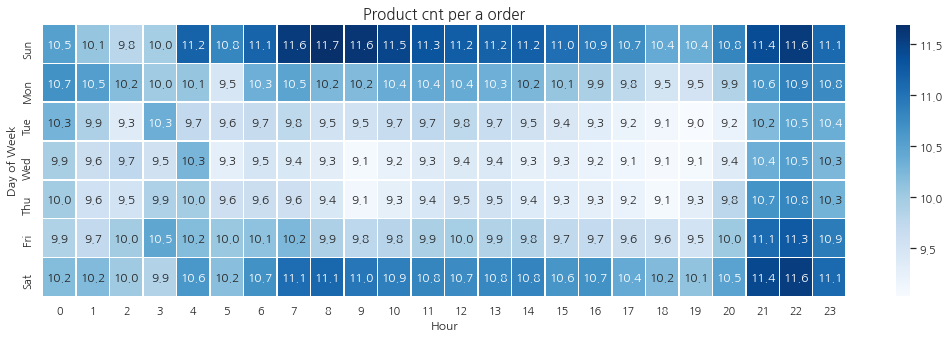

In [21]:
drawWeekHour(order_df, values='product_cnt', title='Product cnt per a order', aggfunc=lambda x: np.mean(x))

### 다시 주문하기까지 걸리는 평균 일수
* 수치가 작을수록 재주문하는데까지 걸리는 시간이 짧다는 것을 의미한다.
* 새벽 시간대(0H ~ 5H)가 다른 시간대에 비해 재주문 텀이 길다.

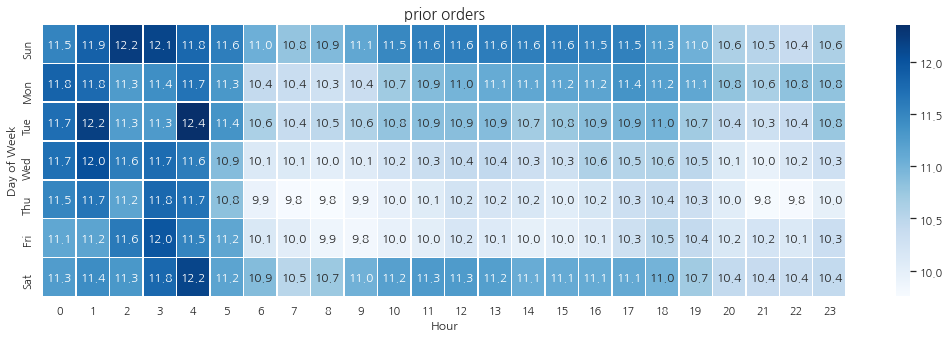

In [22]:
drawWeekHour(order_df, values='days_since_prior_order', title='prior orders', aggfunc=lambda x: np.mean(x))

---------------------

### 📈 재주문량 분석 (Reorder Analysis)
* 주문 횟수가 많아질수록 재주문 텀이 짧아진다. *(그래프 참조)*
* 충성고객들이 주문을 자주 하기 때문에 주문 횟수는 많고 재주문 텀이 짧아지는 것일 듯 하다.

In [23]:
print('Avg days since prior order {} days'.format(round(order_df.days_since_prior_order.mean()), 2))

Avg days since prior order 11 days


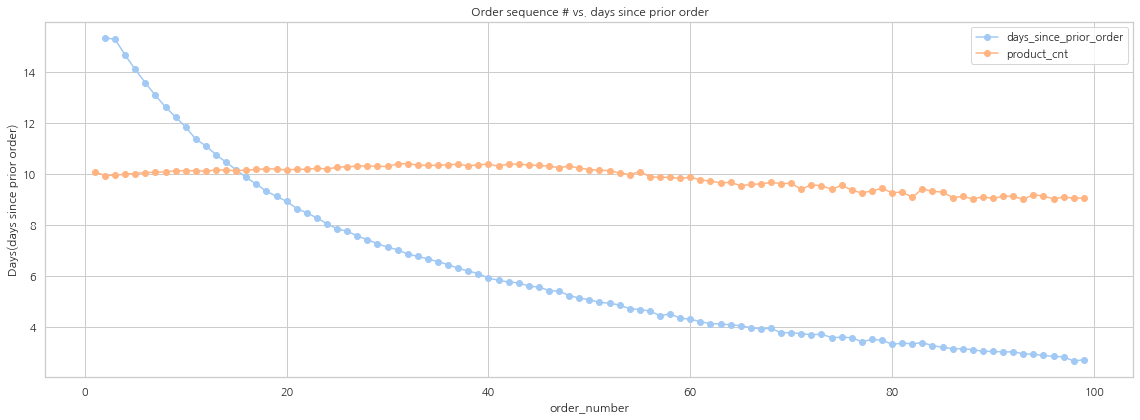

In [24]:
sns.set(style='whitegrid', palette='pastel', font_scale=1, rc={'font.family':'NanumGothic'})

order_df.groupby('order_number').agg({'days_since_prior_order':np.mean, 'product_cnt':np.mean})\
        .plot(figsize=(16,6), title='Order sequence # vs. days since prior order', marker='o')
plt.ylabel('Days(days since prior order)')
plt.tight_layout()
plt.show()

In [25]:
merge_order_products_df = order_products_df.merge(order_df, on='order_id')

In [26]:
reordered_since_days_df = merge_order_products_df.groupby(['days_since_prior_order','reordered']).agg({'product_id':len})
reordered_since_days_df = reordered_since_days_df.reset_index()\
                          .pivot(index='days_since_prior_order', columns='reordered', values='product_id')

In [27]:
reordered_since_days_df['reorder_rate'] = reordered_since_days_df[1]/reordered_since_days_df.sum(axis=1)
avg_reorder_rate = round(reordered_since_days_df[1].sum()/reordered_since_days_df[[0,1]].sum().sum(),2)

재구매 텀이 짧을수록 재구매 비율이 높은 것을 알 수 있다.

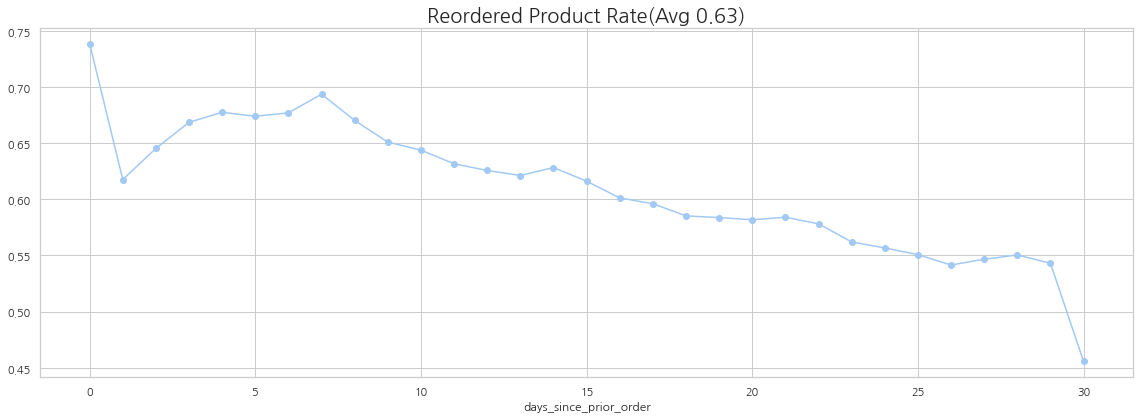

In [28]:
reordered_since_days_df['reorder_rate'].plot(kind='line', marker='o',figsize=(16,6))
plt.title("Reordered Product Rate(Avg {})".format(avg_reorder_rate), fontsize=20)
plt.tight_layout()
plt.show()

In [29]:
reordered_order_num_df = merge_order_products_df.groupby(['order_number','reordered']).agg({'product_id':len})
reordered_order_num_df = reordered_order_num_df.reset_index().pivot(index='order_number', columns='reordered', values='product_id')

In [30]:
reordered_order_num_df['reorder_rate'] = reordered_order_num_df[1]/reordered_order_num_df.sum(axis=1)
avg_reorder_rate = round(reordered_order_num_df[1].sum()/reordered_order_num_df[[0,1]].sum().sum(),2)
reordered_order_num_df.fillna(0, inplace=True)

* **log 함수**의 형태와 유사한 그래프가 나타난다.
* 주문 횟수가 높을수록 즉, 많이 주문하면 재구매율이 높게 나타난다.
* 재구매한 상품이 많았기때문에 주문 횟수가 많았다고 보는 것이 타당할 것이다.

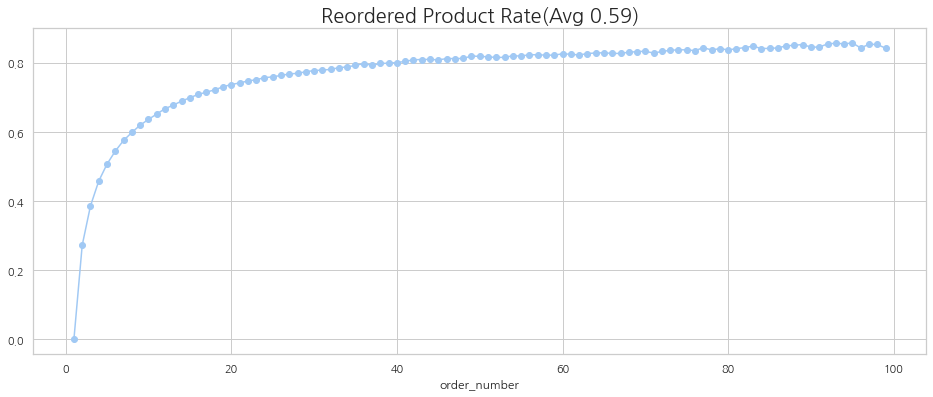

In [31]:
reordered_order_num_df['reorder_rate'].plot(kind='line', marker='o',figsize=(16,6))
plt.title("Reordered Product Rate(Avg {})".format(avg_reorder_rate), fontsize=20)
plt.show()

In [32]:
reorder_products_df = merge_order_products_df.groupby(['product_id']).agg({'order_id':len,
                                                                           'reordered':lambda x: len(x[x>0]),
                                                                           'user_id':lambda x: len(x.unique())})

In [33]:
convert_col_names = {'user_id':'unique_users', 'reordered':'reorder', 'order_id':'total'}
reorder_products_df.columns = [convert_col_names[col] for col in reorder_products_df.columns]

In [34]:
reorder_products_df['reorder_rate'] = round(reorder_products_df.reorder/reorder_products_df.total, 2)
reorder_products_df['order_per_user'] = round(reorder_products_df.total/reorder_products_df.unique_users, 2)
reorder_products_df = reorder_products_df.merge(products_df, left_index=True, right_on='product_id')

In [35]:
reorder_products_df[reorder_products_df.total>1000].sort_values('reorder_rate', ascending=False)\
                   [['product_name', 'total', 'reorder_rate', 'aisle_id', 'order_per_user']][:20]

,product_name,total,reorder_rate,aisle_id,order_per_user
45503,Whole Organic Omega 3 Milk,9108,0.86,84,7.15
9291,Half And Half Ultra Pasteurized,2921,0.86,84,7.23
47230,Ultra-Purified Water,1489,0.86,115,7.02
5513,Organic Homogenized Whole Milk,3970,0.86,84,7.03
43393,Organic Lactose Free Whole Milk,8477,0.86,91,7.09
34196,Goat Milk,5185,0.85,84,6.66
29446,"Milk, Organic, Vitamin D",20198,0.85,84,6.87
38688,Organic Reduced Fat Milk,35663,0.85,84,6.70
31719,Organic Whole Milk,9842,0.84,84,6.30
24520,Lowfat Goat Milk,1159,0.84,84,6.20


1000개 이상 주문한 제품들 중에서 재구매율이 높은 상위 20개 상품을 나열했을 때,\
84구역의 다양한 우유 상품들이 재구매율이 평균 **85%**정도로 가장 높은 것을 확인해볼 수 있다.

유저당 주문 건수도 그와 비례하여 높아진다.

In [36]:
from collections import defaultdict
import operator

def popularWords(names, topn=2):
    wordFrequency = defaultdict(int)
    
    def updateWords(words):
        for word in words:
            if len(word) > 1:
                wordFrequency[word] += 1
    
    names.apply(lambda x:updateWords(x.split()))
    tops = sorted(wordFrequency.items(), key=operator.itemgetter(1), reverse=True)[:topn]
    
    return " ".join([n[0] for n in tops])

In [37]:
aisle_df = products_df.groupby('aisle_id').agg({'product_name':popularWords, 'product_id':lambda x:len(x.unique())})

In [38]:
aisle_order_stat_df = reorder_products_df.groupby('aisle_id').agg({'total':sum, 'reorder':sum})
aisle_order_stat_df['reorder_rate'] = round(aisle_order_stat_df.reorder/aisle_order_stat_df.total, 2)
aisle_order_stat_df = aisle_order_stat_df.merge(aisle_df, left_index=True, right_index=True).sort_values('reorder_rate', ascending=False)
aisle_order_stat_df.index = aisle_order_stat_df.product_name + "(" + aisle_order_stat_df.index.astype(str) + ")"

In [39]:
aisle_order_stat_df

,total,reorder,reorder_rate,product_name,product_id
Milk Fat(84),891015,696264,0.78,Milk Fat,243
Water Sparkling(115),841533,613977,0.73,Water Sparkling,344
Organic Apple(24),3642188,2615469,0.72,Organic Apple,382
Eggs Large(86),452134,318920,0.71,Eggs Large,125
Cucumbers Seedless(32),276028,190662,0.69,Cucumbers Seedless,32
...,...,...,...,...,...
Black Mascara(132),6168,1308,0.21,Black Mascara,178
in Pans(10),9172,1792,0.20,in Pans,218
Bandages Adhesive(118),10872,2118,0.19,Bandages Adhesive,240
Frosting Decorating(97),23692,3962,0.17,Frosting Decorating,290


재구매율이 높은 구역들은 우유, 물, 과일, 계란과 같은 유통기한이 짧은 신선 식료품 위주의 상품으로 구성되어 있는 것으로 보인다.

재구매율이 낮은 구역들은 유통기한이 비교적 긴 상품들로 구성되어 있다.

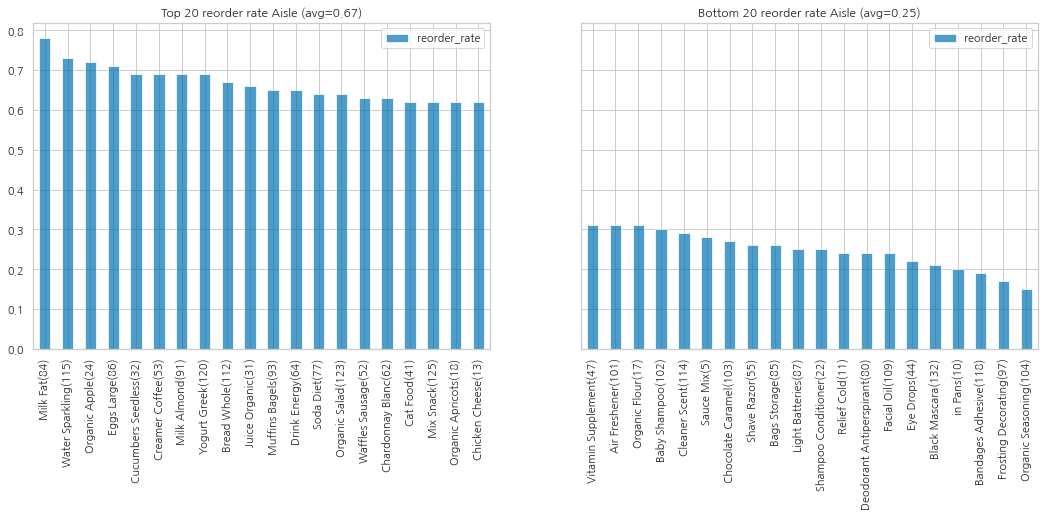

In [40]:
sns.set(style="whitegrid", palette="colorblind", font_scale=1, rc={'font.family':'NanumGothic'} )

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

top20_df = aisle_order_stat_df[['reorder_rate']][:20]
top20_df.plot(kind='bar', figsize=(16,6), alpha=.7, ax=ax1, title='Top 20 reorder rate Aisle (avg={})'\
              .format(toReadable(top20_df.reorder_rate.mean())))

bottom20_df = aisle_order_stat_df[['reorder_rate']][-20:]
bottom20_df.plot(kind='bar', figsize=(18,6), alpha=.7, ax=ax2, title='Bottom 20 reorder rate Aisle (avg={})'\
                 .format(toReadable(bottom20_df.reorder_rate.mean())))
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:2264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


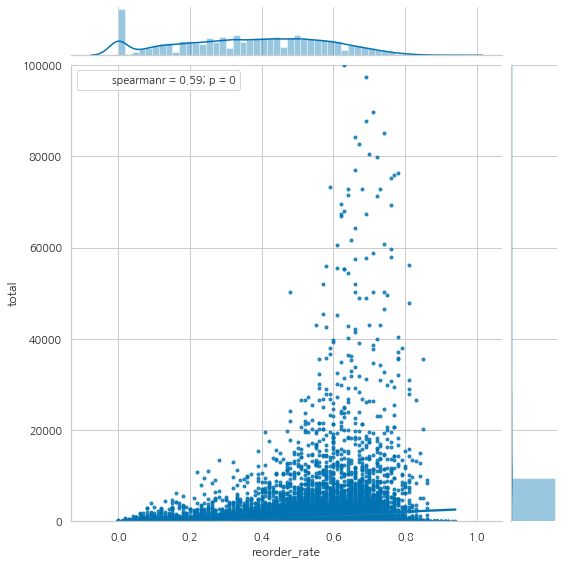

In [41]:
from scipy.stats import spearmanr

g = sns.jointplot("reorder_rate", "total", kind="reg", marker='.', ylim=(0,100000), size=8, ratio=8, 
                  stat_func=spearmanr, data=reorder_products_df)

In [42]:
order_product_list = merge_order_products_df\
                    .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id']].values.tolist()

product_corpus = list()
sentence = list()
new_order_id = order_product_list[0][0]
for (order_id, product_id) in order_product_list:
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))

In [43]:
from gensim.models import Word2Vec

#model = Word2Vec(product_corpus, window=6, vector_size=100, workers=4, min_count=200)
#model.save('results/prod2vec.100d.model')

In [44]:
# 모델 학습 결과 불러오기
model = Word2Vec.load('results/prod2vec.100d.model')

In [45]:
def toProductName(id):
    return products_df[products_df.product_id==id]['product_name'].values.tolist()[0]

In [46]:
toProductName(24852)

'Banana'

In [47]:
def most_similar_readable(model, product_id):
    similar_list = [(product_id, 1.0)]+model.wv.most_similar(str(product_id))
    return [(toProductName(int(id)), similarity) for (id, similarity) in similar_list]

* Banana와의 유사도 체크

In [48]:
pd.DataFrame(most_similar_readable(model, 24852), columns=['product','similarity'])

,product,similarity
0,Banana,1.000000
1,Bag of Organic Bananas,0.698670
2,Seedless Red Grapes,0.584879
3,Bartlett Pears,0.572206
4,XL Emerald White Seedless Grapes,0.524900
5,Organic Banana,0.513034
6,Total 0% Greek Yogurt,0.507830
7,Organic Fuji Apple,0.506543
8,Granny Smith Apples,0.504630
9,Total 2% All Natural Plain Greek Yogurt,0.482216


* Organic Whole Milk와의 유사도 체크

In [49]:
pd.DataFrame(most_similar_readable(model, 27845), columns=['product','similarity'])

,product,similarity
0,Organic Whole Milk,1.000000
1,Organic Reduced Fat Milk,0.777951
2,Whole Organic Omega 3 Milk,0.701105
3,Organic Lowfat 1% Milk,0.699803
4,Organic Lactose Free Whole Milk,0.650275
5,Organic Multigrain Waffles,0.622951
6,1% Lowfat Milk,0.622480
7,Organic Whole Grassmilk Milk,0.609546
8,Organic Mini Homestyle Waffles,0.608241
9,Mild Cheddar Cheese Sticks,0.602570


* Drinking Water와의 유사도 체크

In [50]:
pd.DataFrame(most_similar_readable(model, 40939), columns=['product','similarity'])

,product,similarity
0,Drinking Water,1.000000
1,Nacho Cheese Flavored Tortilla Chips,0.760068
2,Boneless & Skinless Chicken Breasts,0.740605
3,Tea,0.736983
4,Diet,0.733328
5,Organic 2% Milk,0.731764
6,Salted Sweet Cream Butter Quarters,0.725373
7,Margarine,0.723077
8,"100% Juice, Variety Pack",0.720582
9,Movie Theater Butter Microwave Popcorn,0.713042


* Canola Oil과의 유사도 체크

In [51]:
pd.DataFrame(most_similar_readable(model, 48697), columns=['product','similarity'])

,product,similarity
0,Canola Oil,1.000000
1,Light Brown Sugar,0.741715
2,Unsalted Butter,0.724439
3,Panko Bread Crumbs,0.723498
4,Corn Starch,0.710215
5,Unbleached Bread Flour,0.704401
6,Refined Canola Oil,0.699764
7,Whole Wheat Flour,0.698623
8,Unbleached All-Purpose Flour,0.692897
9,Ground White Pepper,0.681324
